# FixedThresholdClassifier: Setting the decision threshold of a binary classifier

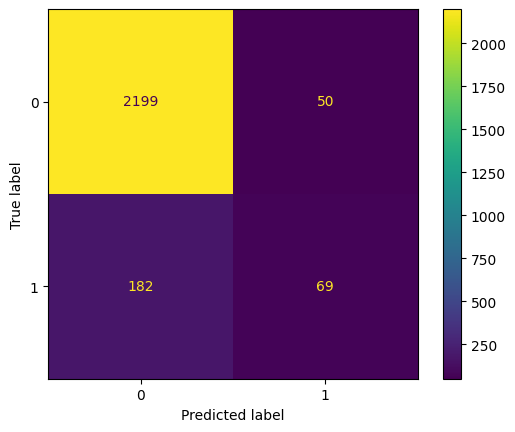

In [7]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay


X, y = make_classification(n_samples=10000, weights=[0.9, 0.1], random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier_05 = LogisticRegression(C=1e6, random_state=0).fit(X_train, y_train)
_ = ConfusionMatrixDisplay.from_estimator(classifier_05, X_test, y_test)

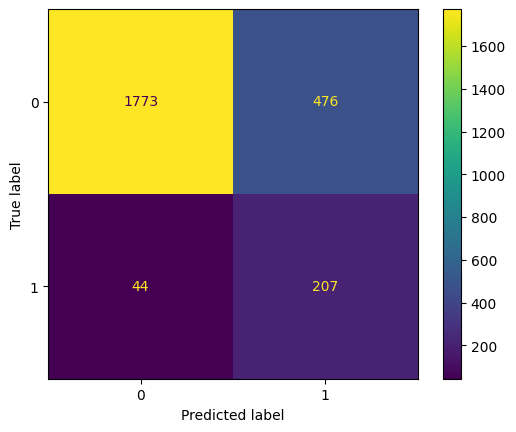

In [8]:
from sklearn.model_selection import FixedThresholdClassifier

classifier_01 = FixedThresholdClassifier(classifier_05, threshold=0.1)
classifier_01.fit(X_train, y_train)
_ = ConfusionMatrixDisplay.from_estimator(classifier_01, X_test, y_test)

# TunedThresholdClassifierCV: Tuning the decision threshold of a binary classifier
The decision threshold of a binary classifier can be tuned to optimize a given metric, using TunedThresholdClassifierCV.

It is particularly useful to find the best decision threshold when the model is meant to be deployed in a specific application context where we can assign different gains or costs for true positives, true negatives, false positives, and false negatives.

Let’s illustrate this by considering an arbitrary case where:

each true positive gains 1 unit of profit, e.g. euro, year of life in good health, etc.;

true negatives gain or cost nothing;

each false negative costs 2;

each false positive costs 0.1.

In [9]:
from sklearn.metrics import confusion_matrix


def custom_score(y_observed, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_observed, y_pred, normalize="all").ravel()
    return tp - 2 * fn - 0.1 * fp


print("Untuned decision threshold: 0.5")
print(f"Custom score: {custom_score(y_test, classifier_05.predict(X_test)):.2f}")

Untuned decision threshold: 0.5
Custom score: -0.12


It is interesting to observe that the average gain per prediction is negative which means that this decision system is making a loss on average.

Tuning the threshold to optimize this custom metric gives a smaller threshold that allows more samples to be classified as the positive class. As a result, the average gain per prediction improves.

In [10]:
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer

custom_scorer = make_scorer(custom_score, response_method="predict", greater_is_better=True)
tuned_classifier = TunedThresholdClassifierCV(classifier_05, cv=5, scoring=custom_scorer).fit(X, y)

print(f"Tuned decision threshold: {tuned_classifier.best_threshold_:.3f}")
print(f"Custom score: {custom_score(y_test, tuned_classifier.predict(X_test)):.2f}")

Tuned decision threshold: 0.071
Custom score: 0.04


We observe that tuning the decision threshold can turn a machine learning-based system that makes a loss on average into a beneficial one.

In practice, defining a meaningful application-specific metric might involve making those costs for bad predictions and gains for good predictions depend on auxiliary metadata specific to each individual data point such as the amount of a transaction in a fraud detection system.

# Performance improvements in PCA

PCA has a new solver, "covariance_eigh", which is up to an order of magnitude faster and more memory efficient than the other solvers for datasets with many data points and few features.

In [11]:
from sklearn.datasets import make_low_rank_matrix
from sklearn.decomposition import PCA

X = make_low_rank_matrix(
    n_samples=10_000, n_features=100, tail_strength=0.1, random_state=0
)

pca = PCA(n_components=10, svd_solver="covariance_eigh").fit(X)
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2f}")

Explained variance: 0.88


In [12]:
from scipy.sparse import random

X = random(10_000, 100, format="csr", random_state=0)

pca = PCA(n_components=10, svd_solver="covariance_eigh").fit(X)
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2f}")

Explained variance: 0.13


# ColumnTransformer is subscriptable

In [13]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X = np.array([[0, 1, 2], [3, 4, 5]])
column_transformer = ColumnTransformer(
    [("std_scaler", StandardScaler(), [0]), ("one_hot", OneHotEncoder(), [1, 2])]
)

column_transformer.fit(X)

print(column_transformer["std_scaler"])
print(column_transformer["one_hot"])

StandardScaler()
OneHotEncoder()


# Custom imputation strategies for the SimpleImputer

In [14]:
from sklearn.impute import SimpleImputer

X = np.array(
    [
        [-1.1, 1.1, 1.1],
        [3.9, -1.2, np.nan],
        [np.nan, 1.3, np.nan],
        [-0.1, -1.4, -1.4],
        [-4.9, 1.5, -1.5],
        [np.nan, 1.6, 1.6],
    ]
)


def smallest_abs(arr):
    """Return the smallest absolute value of a 1D array."""
    return np.min(np.abs(arr))


imputer = SimpleImputer(strategy=smallest_abs)

imputer.fit_transform(X)

array([[-1.1,  1.1,  1.1],
       [ 3.9, -1.2,  1.1],
       [ 0.1,  1.3,  1.1],
       [-0.1, -1.4, -1.4],
       [-4.9,  1.5, -1.5],
       [ 0.1,  1.6,  1.6]])

# Pairwise distances with non-numeric arrays

In [15]:
from sklearn.metrics import pairwise_distances

X = ["cat", "dog"]
Y = ["cat", "fox"]


def levenshtein_distance(x, y):
    """Return the Levenshtein distance between two strings."""
    if x == "" or y == "":
        return max(len(x), len(y))
    if x[0] == y[0]:
        return levenshtein_distance(x[1:], y[1:])
    return 1 + min(
        levenshtein_distance(x[1:], y),
        levenshtein_distance(x, y[1:]),
        levenshtein_distance(x[1:], y[1:]),
    )


pairwise_distances(X, Y, metric=levenshtein_distance)

array([[0., 3.],
       [3., 2.]])